1. 기본적인 feature engineering을 통한 데이터를 이용하여 ml model에 적용하였을 때, 성능을 확인한다(base line)
- LGBM(0.8641304347826086)

2. 추후에 eda를 통한 새로운 feature를 추가하면 어떻게 변하는지 살펴보자

3. 2의 결과 성능이 향상되면 hyperparameter tuning까지 기대해볼 수 있다

4. 최종적으로 Stack과 Bagging으로 성능을 끌어올려보자

# EDA


1. target

2. feature와 target의 관계

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [63]:
# load
data = pd.read_csv('dataset/train.csv', index_col = 0)
data.shape

(17480, 15)

# Target
* 0 = <=50K (5만 달러 이하)
* 1 = >50K (5만 달러 초과) 

In [64]:
data

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,target
id,,,,,,,,,,,,,,,
0,32,Private,309513,Assoc-acdm,12,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
1,33,Private,205469,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
2,46,Private,149949,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,0
3,23,Private,193090,Bachelors,13,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,United-States,0
4,55,Private,60193,HS-grad,9,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17475,35,NaN,320084,Bachelors,13,Married-civ-spouse,NaN,Wife,White,Female,0,0,55,United-States,1
17476,30,NaN,33811,Bachelors,13,Never-married,NaN,Not-in-family,Asian-Pac-Islander,Female,0,0,99,United-States,0
17477,71,NaN,287372,Doctorate,16,Married-civ-spouse,NaN,Husband,White,Male,0,0,10,United-States,1


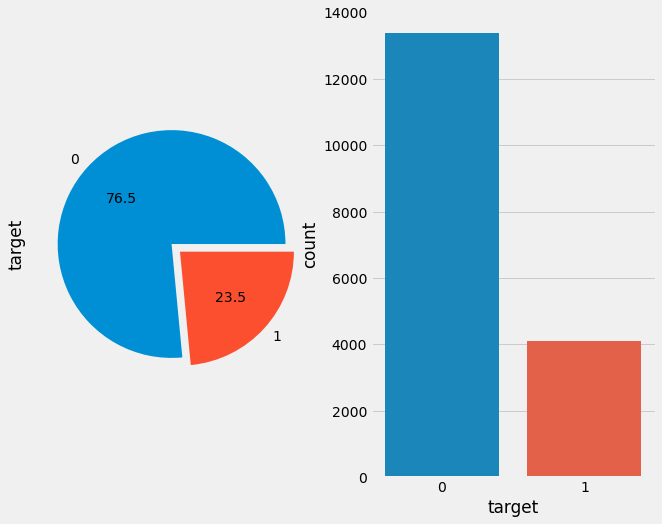

0    13374
1     4106
Name: target, dtype: int64

In [3]:
# target
f, ax = plt.subplots(1,2,figsize=(10,8))
sns.countplot('target', data = data, ax = ax[1])
data['target'].value_counts().plot.pie(explode=[0, 0.1], autopct='%.1f', ax=ax[0])
plt.show()

data['target'].value_counts()

- 관측 결과
1) classification
2) 일단 target 자체가 굉장히 rough하게 잡음
3) 0과 1이 3:1정도 비율인데 1을 조금 더 채우는 것이 도움이 될 것 같음

# 데이터 전처리
1. Label encoding
2. 결측값 처리
3. object형 데이터
4. 이상치 처리


### 1. 문자로 되어 있는 데이터 label encoding

In [4]:
# 결측값 확인
data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

In [5]:
# catch the columns with na values
mis_var_col = []
for col in data.columns:
    if data[col].isnull().sum() > 0:
        print('{} has {}({:2.2f}%%) missing values'.format(col, data[col].isnull().sum(), 100*data[col].isnull().sum()/len(data[col])))
        mis_var_col.append(col)

workclass has 1836(10.50%%) missing values
occupation has 1843(10.54%%) missing values
native.country has 583(3.34%%) missing values


In [6]:
from sklearn.preprocessing import LabelEncoder
not_miss_categorical = [col for col in data.columns if data[col].dtype=='object' and col not in mis_var_col]
for col in not_miss_categorical:
    print(col)
    le = LabelEncoder()
    le.fit(data[col])
    data.loc[:, col] = le.transform(data[col])


education
marital.status
relationship
race
sex


### 2. 결측값 처리
- target과의 관계 살펴보기
- if enough information, RF를 이용하여 예측

- 관측결과
1. target(0)에 대한 정보를 제공할 수 있음
2. native.country의 경우 미국가 그 외의 국가로 나누자
3. 다른 categorical feature를 통해 결측값 예측


In [7]:
def countplot_(feature):
    f, ax = plt.subplots(1,2, figsize=(10,6))
    plt.sca(ax[0])
    sns.countplot(x=feature, data=data, ax=ax[0])
    plt.xticks(rotation=90)

    plt.sca(ax[1])
    sns.countplot(x=feature, hue='target', data=data, ax=ax[1])
    plt.xticks(rotation=90)
    plt.show()

In [8]:
# from collections import Counter
# index = []
# index.extend(data[data[mis_var_col[0]].isnull()].index)
# index.extend(data[data[mis_var_col[1]].isnull()].index)
# index.extend(data[data[mis_var_col[2]].isnull()].index)

# mis_index = []
# for k, v in Counter(index).items():
#     if v>=2: mis_index.append(k)

# len(mis_index)
# del index
# data.drop(mis_index, axis=0, inplace=True)
# data.shape

In [9]:
data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
target               0
dtype: int64

### workclass

- private에 비해 다른 것들은 sample수가 너무 적어서 오히려 안좋을것 같음 $\rightarrow$ not_private으로 묶어주자

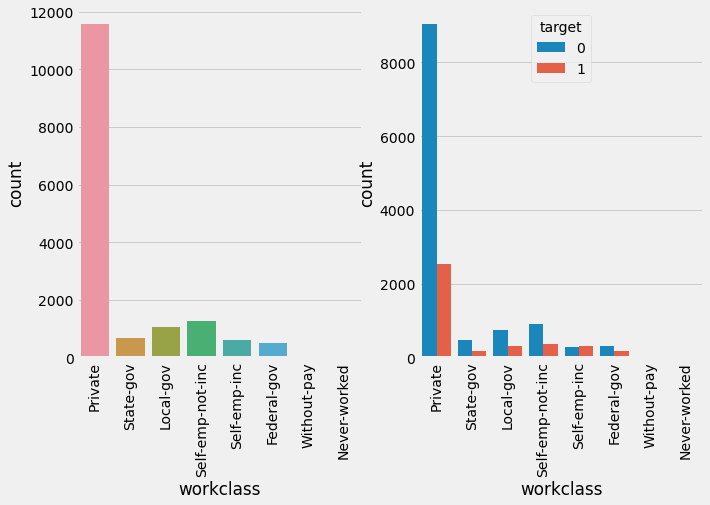

workclass,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay
target,,,,,,,,
0,302,736,7,9036,271,899,472,6
1,183,317,0,2532,323,373,187,0


In [10]:
feature = 'workclass'
countplot_(feature)
pd.crosstab(data['target'], data[feature]).style.background_gradient(cmap='summer_r')

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

# null: test, notNull: train
nullIndex = data[data[feature].isnull()==True].index
notNullIndex = data[data[feature].isnull()==False].index

# select the data
selected_features = ['age', 'fnlwgt', 'education.num', 'sex','capital.gain', 'capital.loss', 'hours.per.week']
label = 'workclass'
X_train = data.loc[notNullIndex, selected_features]
X_test = data.loc[nullIndex, selected_features]

y_train = data.loc[notNullIndex, label]


print(X_train.shape, y_train.shape, X_test.shape)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
data.loc[nullIndex, label] = predictions
data[feature]

(15644, 7) (15644,) (1836, 7)


id
0          Private
1          Private
2          Private
3          Private
4          Private
           ...    
17475      Private
17476      Private
17477    State-gov
17478      Private
17479      Private
Name: workclass, Length: 17480, dtype: object

In [12]:
data.loc[nullIndex, label].value_counts()

Private             1660
Self-emp-not-inc     111
Local-gov             24
State-gov             18
Self-emp-inc          12
Federal-gov           11
Name: workclass, dtype: int64

In [13]:
# Private과 이 이외로 묶어주자
index = data[data[feature]!='Private'][feature].index
data.loc[index, feature] = 'Not_private'

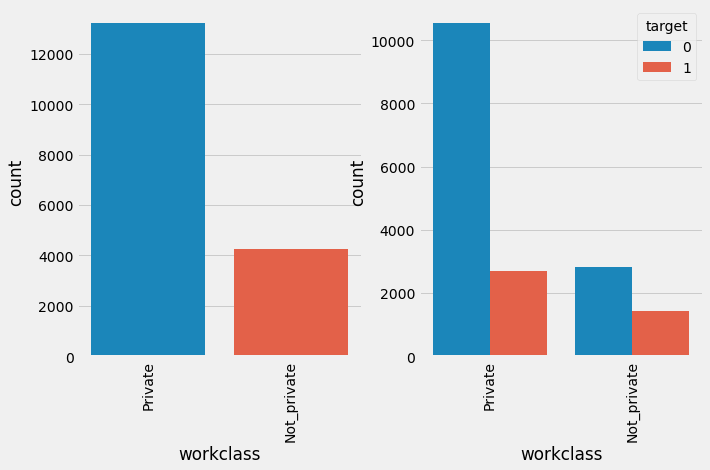

Private        13228
Not_private     4252
Name: workclass, dtype: int64

In [14]:
countplot_(feature)
data[feature].value_counts()

### occupation

- 버리긴 아까운 변수
- RF를 이용해서 체우자
- 1이 차지하는 비중을 기준으로 구분시키자
1. good $\rightarrow$ 'Exec-managerial', 'Protective-serv', 'Craft-repair', 'Sales', 'Adm-clerical', 'Tech-support'
2. 'not_good'

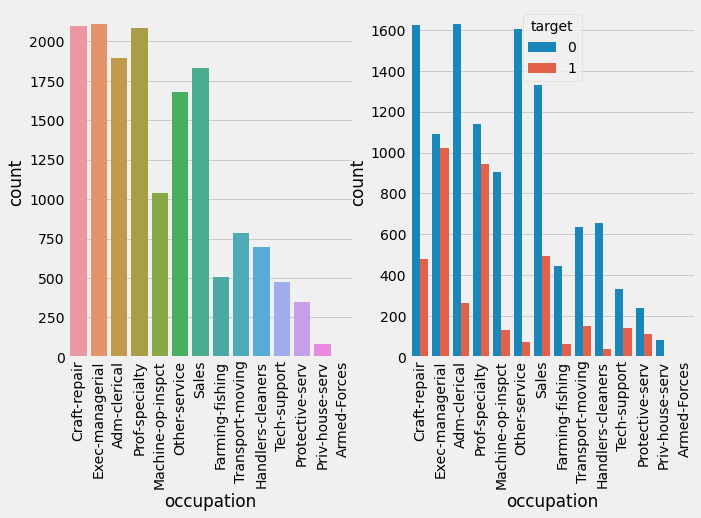

occupation,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving
target,,,,,,,,,,,,,,
0,1631,3,1624,1090,443,656,907,1605,83,1142,237,1333,333,635
1,262,0,477,1023,65,39,133,72,0,943,113,496,142,150


In [15]:
feature = 'occupation'
countplot_(feature)
pd.crosstab(data['target'], data[feature]).style.background_gradient(cmap='summer_r')

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
# null: test, notNull: train
nullIndex = data[data[feature].isnull()==True].index
notNullIndex = data[data[feature].isnull()==False].index

# select the data
selected_features = ['age', 'fnlwgt', 'education.num', 'sex','capital.gain', 'capital.loss', 'hours.per.week']
label = 'occupation'
X_train = data.loc[notNullIndex, selected_features]
X_test = data.loc[nullIndex, selected_features]

y_train = data.loc[notNullIndex, label]


print(X_train.shape, y_train.shape, X_test.shape)


# prediction
model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
data.loc[nullIndex, label] = predictions
data[feature]

(15637, 7) (15637,) (1843, 7)


id
0           Craft-repair
1        Exec-managerial
2           Craft-repair
3           Adm-clerical
4           Adm-clerical
              ...       
17475     Prof-specialty
17476     Prof-specialty
17477     Prof-specialty
17478      Other-service
17479       Adm-clerical
Name: occupation, Length: 17480, dtype: object

In [18]:
data.loc[nullIndex, label].value_counts()

Other-service        393
Adm-clerical         289
Sales                256
Prof-specialty       187
Exec-managerial      178
Craft-repair         172
Machine-op-inspct    106
Handlers-cleaners     90
Farming-fishing       57
Transport-moving      56
Tech-support          26
Protective-serv       22
Priv-house-serv       11
Name: occupation, dtype: int64

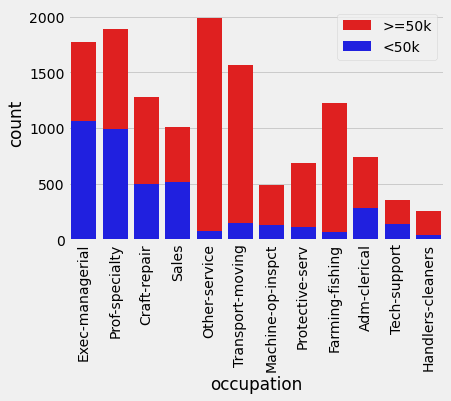

In [19]:
index = data[data['target'] != 1].index
sns.countplot(data.loc[index, feature], color='red', label = '>=50k')
index = data[data['target'] == 1].index
sns.countplot(data.loc[index, feature], color='blue', label = '<50k')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [20]:
f = ['Exec-managerial', 'Prof-specialty', 'Craft-repair', 'Sales', 'Adm-clerical']
index = data[data[feature] == f[0]].index
data.loc[index, feature] = 'best'

index = data[data[feature] == f[1]].index
data.loc[index, feature] = 'best'

index = data[data[feature] == f[2]].index
data.loc[index, feature] = 'good'

index = data[data[feature] == f[3]].index
data.loc[index, feature] = 'good'

index = data[data[feature] == f[4]].index
data.loc[index, feature] = 'good'

index = data[(data[feature] != 'best') & (data[feature] != 'good')].index
data.loc[index, feature] = 'not_good'

data[feature].value_counts()
# index.shape

good        6540
not_good    6377
best        4563
Name: occupation, dtype: int64

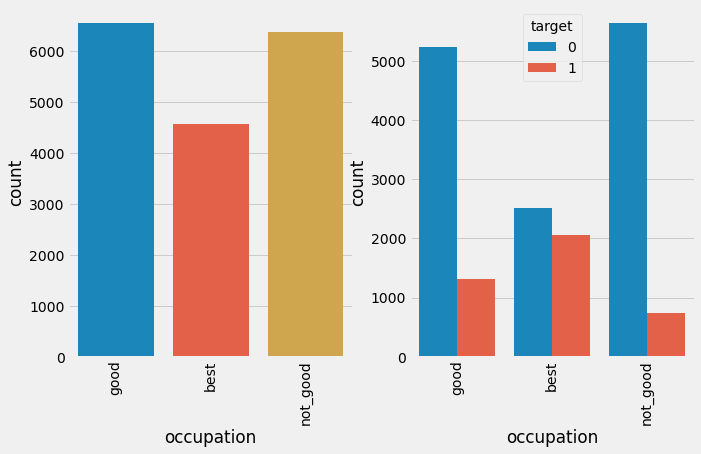

In [21]:
countplot_(feature)

### native.country

- 미국인이 90퍼센트
- 미국인이건 아니건 20%정도가 1임
- 결측은 미국인으로 체우자
- 미국과 아닌 국가로 나누기

In [22]:
feature = 'native.country'
data[feature].value_counts()

United-States                 15393
Mexico                          355
Philippines                     108
Germany                          75
Canada                           63
Puerto-Rico                      59
El-Salvador                      58
Cuba                             49
India                            47
England                          46
Jamaica                          42
China                            40
South                            39
Italy                            38
Dominican-Republic               38
Columbia                         37
Guatemala                        36
Poland                           35
Japan                            33
Vietnam                          32
Taiwan                           28
Haiti                            23
Nicaragua                        20
Portugal                         20
Ecuador                          19
Ireland                          18
Iran                             17
Peru                        

In [23]:
us = 13734
leng = data[feature].value_counts().sum()
print('US percentage',us/leng*100)

US percentage 81.28070071610345


In [24]:
# us의 target 비율 확인
print(3704/(11689+3704))
data[data[feature] == 'United-States']['target'].value_counts()

0.24062885727278632


0    11689
1     3704
Name: target, dtype: int64

In [25]:
# 미국인이 아닌 사람들의 비율
print(402/(1523+402))
data[data[feature] != 'United-States']['target'].value_counts()

0.20883116883116884


0    1685
1     402
Name: target, dtype: int64

In [26]:
data[feature].fillna('United-States', inplace=True)

In [27]:
data['country'] = 'US'
index = data[data[feature] != 'United-States'].index
data.loc[index, 'country'] = 'NOT_US'
data.drop(feature, axis=1, inplace=True)

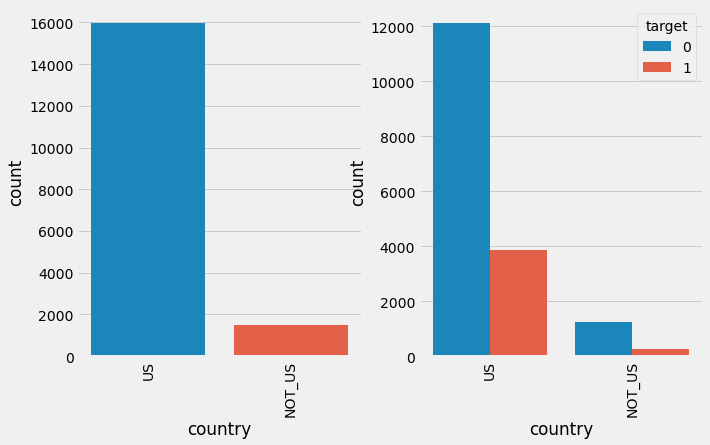

In [28]:
countplot_('country')

In [29]:
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
target            0
country           0
dtype: int64

# 3. 데이터 처리

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17480 entries, 0 to 17479
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             17480 non-null  int64 
 1   workclass       17480 non-null  object
 2   fnlwgt          17480 non-null  int64 
 3   education       17480 non-null  int32 
 4   education.num   17480 non-null  int64 
 5   marital.status  17480 non-null  int32 
 6   occupation      17480 non-null  object
 7   relationship    17480 non-null  int32 
 8   race            17480 non-null  int32 
 9   sex             17480 non-null  int32 
 10  capital.gain    17480 non-null  int64 
 11  capital.loss    17480 non-null  int64 
 12  hours.per.week  17480 non-null  int64 
 13  target          17480 non-null  int64 
 14  country         17480 non-null  object
dtypes: int32(5), int64(7), object(3)
memory usage: 2.3+ MB


skew: 0.5743383756153351
kurt: -0.2153904292265132
LOG transformation
skew: -0.10872908851624608
kurt: -0.8117761629760909


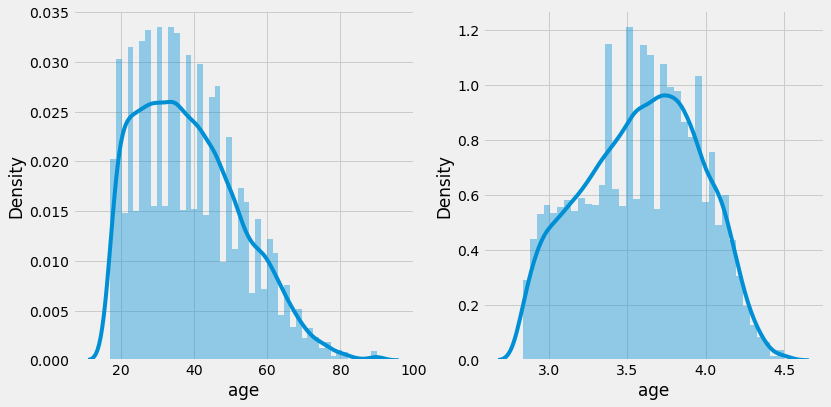

In [31]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
f = 'age'
sns.distplot(data[f], ax=ax[0])
print('skew:', data[f].skew())
print('kurt:', data[f].kurt())

print('LOG transformation')
sns.distplot(np.log(data[f]), ax=ax[1])
print('skew:', np.log(data[f]).skew())
print('kurt:', np.log(data[f]).kurt())

data['log_age'] = np.log(data[f])
data.drop([f], axis=1, inplace=True)

In [32]:
f = 'workclass'
new_cols = pd.get_dummies(data[f])
data = pd.concat([data, new_cols], axis=1)
data.drop([f], axis=1, inplace=True)
data.shape

(17480, 16)

In [33]:
data.head()

,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,target,country,log_age,Not_private,Private
id,,,,,,,,,,,,,,,,
0,309513,7,12,2,good,0,4,1,0,0,40,0,US,3.465736,0,1
1,205469,15,10,2,best,0,4,1,0,0,40,1,US,3.496508,0,1
2,149949,15,10,2,good,0,4,1,0,0,40,0,US,3.828641,0,1
3,193090,9,13,4,good,3,4,0,0,0,30,0,US,3.135494,0,1
4,60193,11,9,0,good,1,4,0,0,0,40,0,US,4.007333,0,1


skew: 1.4019637652624537
kurt: 5.973739842307609
LOG transformation
skew: -0.8633011457359946
kurt: 0.8740054580533205


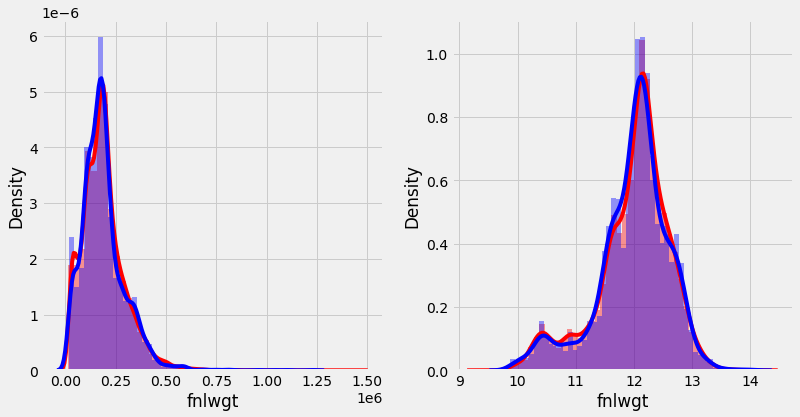

In [34]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
f = 'fnlwgt'
sns.distplot(data[data['target']==0][f], ax=ax[0],color='red')
sns.distplot(data[data['target']==1][f], ax=ax[0],color='blue')
print('skew:', data[f].skew())
print('kurt:', data[f].kurt())

print('LOG transformation')
sns.distplot(np.log(data[data['target']==0][f]), ax=ax[1],color='red')
sns.distplot(np.log(data[data['target']==1][f]), ax=ax[1],color='blue')
print('skew:', np.log(data[f]).skew())
print('kurt:', np.log(data[f]).kurt())

data[f'log_{f}'] = np.log(data[f])
data.drop([f], axis=1, inplace=True)

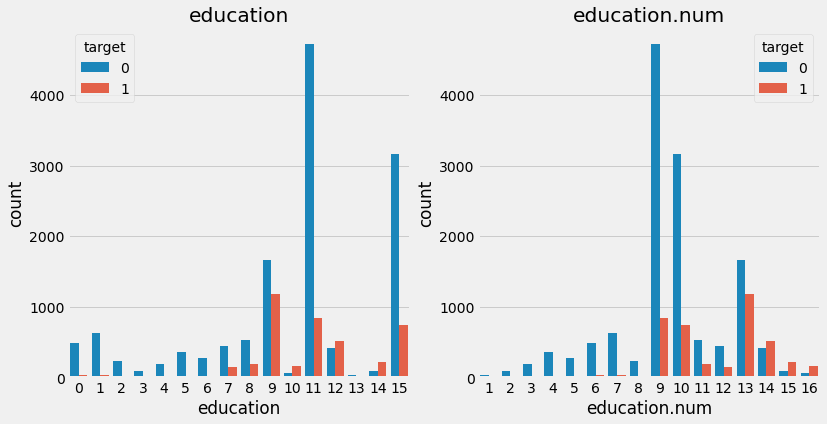

In [35]:
# education : 교육수준
# education.num : 교육수준 번호
f, ax = plt.subplots(1,2,figsize=(12,6))
sns.countplot(x='education',hue='target', data=data, ax=ax[0])
ax[0].set(title='education')
sns.countplot(x='education.num',hue='target', data=data, ax=ax[1])
ax[1].set(title='education.num')
plt.show()

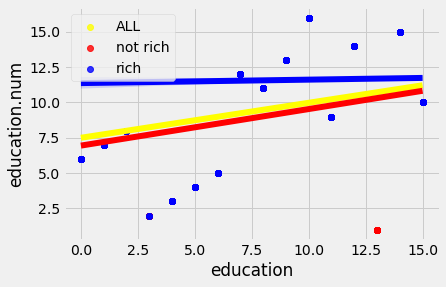

In [36]:
x = data[['education.num','education','target']]
x0 = x[x['target']==0]
x1 = x[x['target']==1]
sns.regplot(y='education.num', x='education',data=x, color='yellow', label='ALL')
sns.regplot(y='education.num', x='education',data=x0, color='red', label='not rich')
sns.regplot(y='education.num', x='education',data=x1, color='blue', label='rich')
plt.legend()
plt.show()

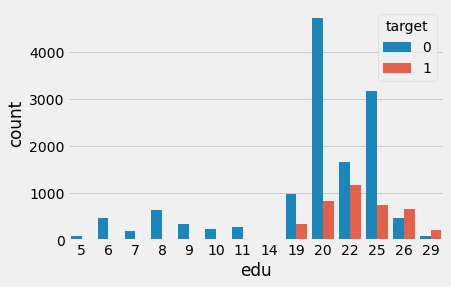

In [37]:
data['edu'] = data['education']+data['education.num']
sns.countplot(x='edu',hue='target', data=data)
plt.show()

In [38]:
data.drop(['education','education.num'], axis=1, inplace=True)
index = data[data['edu']<19].index
data.loc[index, 'edu'] = 0

index = data[(data['edu']==19) | (data['edu']==20) | (data['edu']==25)].index
data.loc[index, 'edu'] = 1

index = data[(data['edu']==22) | (data['edu']==26) | (data['edu']==29)].index
data.loc[index, 'edu'] = 2
data.head()

,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,target,country,log_age,Not_private,Private,log_fnlwgt,edu
id,,,,,,,,,,,,,,,
0,2,good,0,4,1,0,0,40,0,US,3.465736,0,1,12.642755,1
1,2,best,0,4,1,0,0,40,1,US,3.496508,0,1,12.233050,1
2,2,good,0,4,1,0,0,40,0,US,3.828641,0,1,11.918051,1
3,4,good,3,4,0,0,0,30,0,US,3.135494,0,1,12.170912,2
4,0,good,1,4,0,0,0,40,0,US,4.007333,0,1,11.005311,1


* 순서가 중요하므로 one-hot하지 않는다

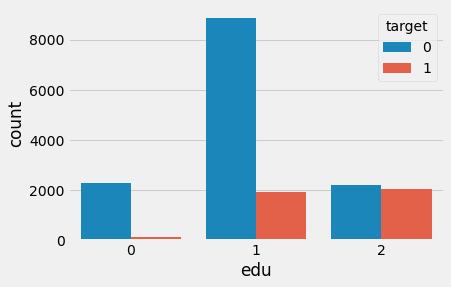

In [39]:
sns.countplot(x='edu',hue='target', data=data)
plt.show()


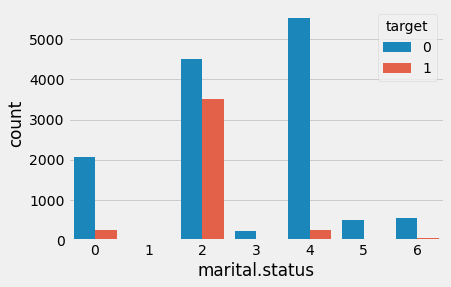

In [40]:
f = 'marital.status'
sns.countplot(x=f,hue='target', data=data)
plt.show()

In [41]:
index = data[data[f]!=2].index
data.loc[index, f] = 0

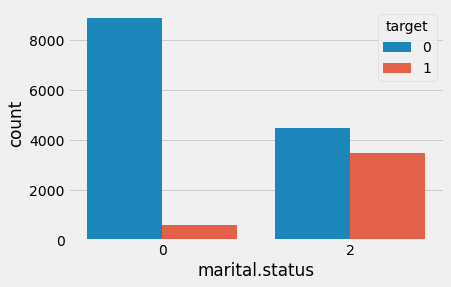

In [42]:
sns.countplot(x=f,hue='target', data=data)
plt.show()

In [43]:
f = 'marital.status'
new_cols = pd.get_dummies(data[f], prefix='marital')
data = pd.concat([data, new_cols], axis=1)
data.drop(f, axis=1, inplace=True)
data.shape

(17480, 16)

(17480, 18)

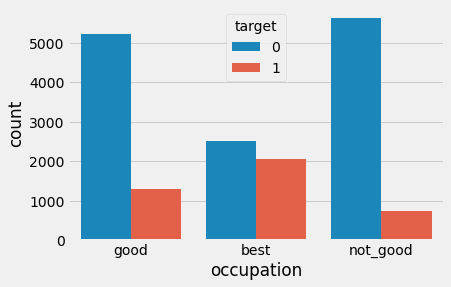

In [44]:
f = 'occupation'
sns.countplot(x=f,hue='target', data=data)
new_cols = pd.get_dummies(data[f], prefix='occ')
data = pd.concat([data, new_cols], axis=1)
data.drop(f, axis=1, inplace=True)
data.shape

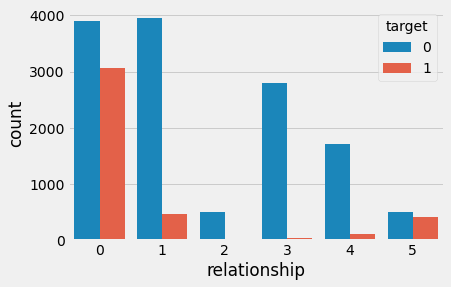

0    6972
1    4415
3    2834
4    1822
5     904
2     533
Name: relationship, dtype: int64

In [45]:
f = 'relationship'
sns.countplot(x=f,hue='target', data=data)
plt.show()
data[f].value_counts()

(17480, 19)

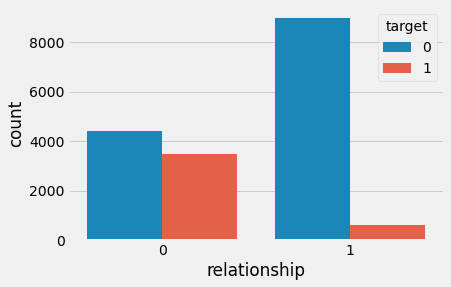

In [46]:
index = data[(data[f]==0) | (data[f]==5)].index
data.loc[index, f] = 0

index = data[(data[f]!=0) & (data[f]!=5)].index
data.loc[index, f] = 1
f = 'relationship'
sns.countplot(x=f,hue='target', data=data)
new_cols = pd.get_dummies(data[f], prefix='relation')
data = pd.concat([data, new_cols], axis=1)
data.drop(f, axis=1, inplace=True)
data.shape

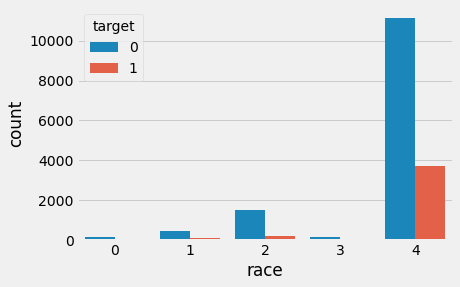

4    14864
2     1702
1      586
0      165
3      163
Name: race, dtype: int64

In [47]:
f = 'race'
sns.countplot(x=f,hue='target', data=data)
plt.show()
data[f].value_counts()

(17480, 20)

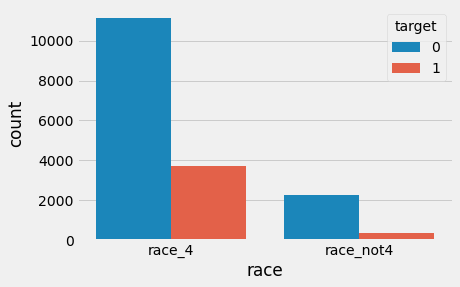

In [48]:
index = data[(data[f]==4)].index
data.loc[index, f] = 'race_4'

index = data[(data[f]!='race_4')].index
data.loc[index, f] = 'race_not4'

new_cols = pd.get_dummies(data[f], prefix='race')
new_cols.value_counts()

sns.countplot(x=f,hue='target', data=data)
new_cols = pd.get_dummies(data[f])
data = pd.concat([data, new_cols], axis=1)
data.drop(f, axis=1, inplace=True)
data.shape

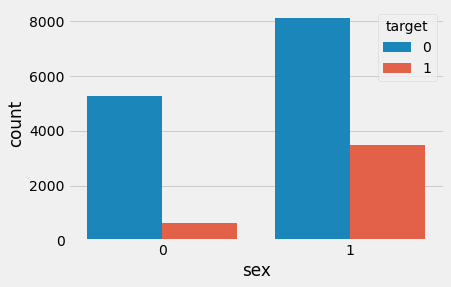

In [49]:
f = 'sex'
new_cols = pd.get_dummies(data[f], prefix='sex')

sns.countplot(x=f,hue='target', data=data)
data = pd.concat([data, new_cols], axis=1)
data.drop(f, axis=1, inplace=True)

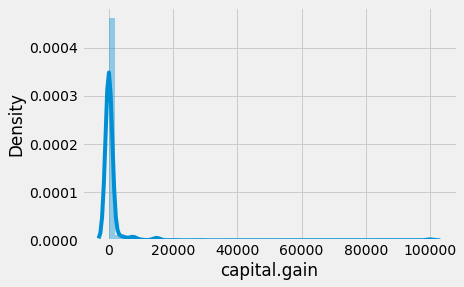

In [50]:
# capital.gain : 자본 이익
# capital.loss : 자본 손실
f = 'capital.gain'
sns.distplot(data[f])
data[f].value_counts()
data.drop([f], axis=1, inplace=True)

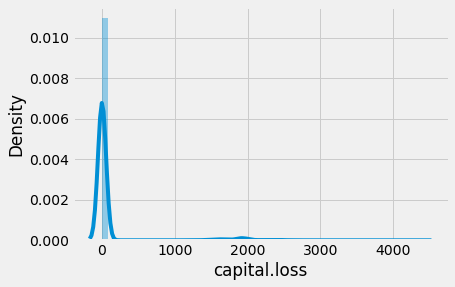

In [51]:
f = 'capital.loss'
sns.distplot(data[f])
data[f].value_counts()
data.drop([f], axis=1, inplace=True)

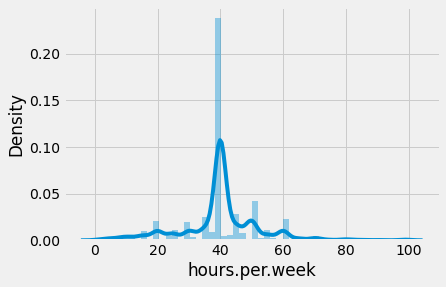

In [52]:
f = 'hours.per.week'
sns.distplot(data[f])
plt.show()

In [53]:
pd.crosstab(data['target'], data[f]).style.background_gradient(cmap='summer_r')

hours.per.week,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,72,73,74,75,76,78,80,81,82,84,85,87,88,90,91,92,94,96,97,98,99
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16,21,29,39,40,34,16,80,11,154,6,99,13,14,211,111,19,40,7,655,13,16,10,133,362,10,16,41,3,614,3,121,21,16,640,94,64,193,11,6463,16,82,57,66,583,23,10,185,8,783,6,42,11,12,185,33,4,10,0,420,0,9,6,3,76,7,0,4,100,26,1,1,21,0,3,41,1,1,16,4,1,1,13,2,1,1,1,1,5,33
1,2,6,0,2,2,6,3,8,1,13,0,11,1,0,11,7,1,4,0,42,2,2,0,19,17,1,0,3,0,50,0,14,2,1,99,18,10,43,4,1679,5,42,24,44,353,14,5,69,2,653,2,23,1,10,173,26,6,4,1,346,1,3,3,3,51,0,1,1,61,14,1,0,8,1,2,34,0,0,10,2,0,0,7,0,0,0,1,0,1,14


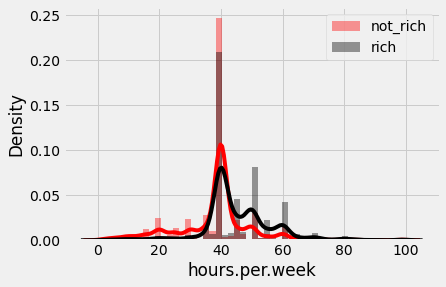

In [54]:
index0 = data[data['target']==0].index
index1 = data[data['target']==1].index
sns.distplot(data.loc[index0, f], color = 'red', label = 'not_rich')
sns.distplot(data.loc[index1, f], color = 'black', label = 'rich')
plt.legend()
plt.show()


In [55]:
f = 'hours.per.week'
data.drop(f, axis=1, inplace=True)

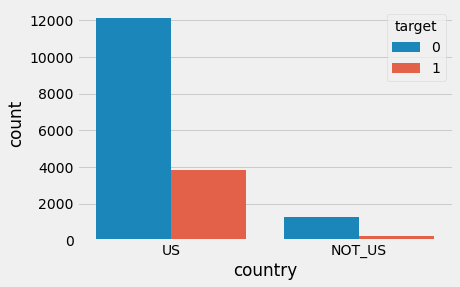

In [56]:
f = 'country'
new_cols = pd.get_dummies(data[f], prefix=f)

sns.countplot(x=f,hue='target', data=data)
data = pd.concat([data, new_cols], axis=1)
data.drop(f, axis=1, inplace=True)

In [57]:
data.head()

,target,log_age,Not_private,Private,log_fnlwgt,edu,marital_0,marital_2,occ_best,occ_good,occ_not_good,relation_0,relation_1,race_4,race_not4,sex_0,sex_1,country_NOT_US,country_US
id,,,,,,,,,,,,,,,,,,,
0,0,3.465736,0,1,12.642755,1,0,1,0,1,0,1,0,1,0,0,1,0,1
1,1,3.496508,0,1,12.233050,1,0,1,1,0,0,1,0,1,0,0,1,0,1
2,0,3.828641,0,1,11.918051,1,0,1,0,1,0,1,0,1,0,0,1,0,1
3,0,3.135494,0,1,12.170912,2,1,0,0,1,0,0,1,1,0,1,0,0,1
4,0,4.007333,0,1,11.005311,1,1,0,0,1,0,0,1,1,0,1,0,0,1


In [58]:
data.shape

(17480, 19)

# Tree 기반 모델링

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

names = ['DT', 'RF', 'XGB', 'LGBM', 'CBM']
models = []
models.append(DecisionTreeClassifier(random_state=0))
models.append(RandomForestClassifier(random_state=0))
models.append(XGBClassifier(random_state=0))
models.append(LGBMClassifier(random_state=0))
models.append(CatBoostClassifier(random_state=0))

In [60]:
y_train = data['target']
X_train = data.drop(['target'], axis=1)
X_train.shape, y_train.shape

((17480, 18), (17480,))

### 5 fold CV of DT ###
CV mean:0.769394 +- std:0.004972

### 5 fold CV of RF ###
CV mean:0.803719 +- std:0.002567

### 5 fold CV of XGB ###
CV mean:0.821968 +- std:0.002970

### 5 fold CV of LGBM ###
CV mean:0.829577 +- std:0.005413

### 5 fold CV of CBM ###
CV mean:0.828032 +- std:0.006904



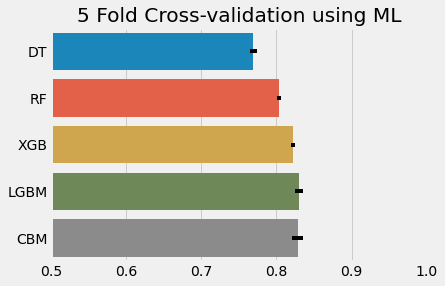

In [61]:
from sklearn.model_selection import KFold, cross_val_score
kfold = KFold(n_splits=5, shuffle=True)

cv_results = []
for i in range(len(names)):
    print(f'### 5 fold CV of {names[i]} ###')
    cv_result = cross_val_score(models[i], X_train, y_train, 
                                cv=kfold, scoring='accuracy', n_jobs=-1)
    cv_results.append(cv_result)
    print(f'CV mean:{cv_result.mean():.6f} +- std:{cv_result.std():.6f}\n')


cv_means = [ x.mean() for x in cv_results ]
cv_std = [ x.std() for x in cv_results ]
cv = {
    'models':names,
    'cv_means':cv_means,
    'cv_std':cv_std
}
sns.barplot(y='models', x='cv_means', 
            data=cv, orient='h', 
            **{'xerr':cv_std})
plt.title("5 Fold Cross-validation using ML")
plt.xlim(0.5, 1)
plt.show()